In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def load_dataset(filepath): # loadind data from given filepath
    if filepath.endswith('.csv'): # read only csv file
        df=pd.read_csv(filepath)
        print(f'Successfully load data "{filepath}"\nData shape:{df.shape}') # print message if successfully load data 
        return df
    raise Exception(f"Fail to load data: Given filepath '{filepath}' is not ending with .csv") # return error if data is not .csv

def pie_plt(df, col_ls): # create pie plots for columns in given list
    num_plt = len(col_ls)
    fig, ax = plt.subplots(1, num_plt, figsize=(4.5*num_plt, 4.5), tight_layout=True)
    for i in range(num_plt): # iterate all given columns to create pie plot
        df[col_ls[i]].value_counts().plot.pie(autopct='%1.2f%%', ax=ax[i], label='')
        ax[i].set_title(f'{col_ls[i]} ratio') # set title as column name on each plot
    fig.suptitle('Pie plot')

def hist_plt(df, col_ls): # create histogram for columns in given list
    num_plt = len(col_ls)
    fig, ax = plt.subplots(1, num_plt, figsize=(4.5*num_plt, 4.5), tight_layout=True)
    for i in range(num_plt): # iterate all given columns to create histogram
        sns.histplot(data=df, x=col_ls[i], kde=True, bins=20, ax=ax[i])
    fig.suptitle('Distribution plot')

def encoder(df, mapper): # encode non-numeric values to numeric value
    for key, value in mapper.items(): # iterate all columns and mapping values for each values in column
        df = df.replace({key: value})
        print(f'Successfully encoded "{key}"column with {value}') # print message if successfully encode column
    return df

def correlations(df, target_column, figsize): # show pearson correlation between all columns and all target column
    fig, ax = plt.subplots(1,2, figsize=figsize, tight_layout=True)

    corr = df.corr(method = 'pearson') # crrelation of all combination
    mask = np.triu(np.ones_like(df.corr()))
    sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5, ax=ax[0], cbar=False, mask=mask)
    # ax[0].tick_params(axis='both', which='major', labelsize=3)
    ax[0].set_title('Correlation of all columns')

    target_corr = corr[target_column] # correlation with target column
    target_corr_sorted = target_corr.sort_values(ascending=False)
    sns.heatmap(target_corr_sorted.to_frame(), annot=True, fmt=".2f", linewidth=.5, ax=ax[1])
    ax[1].set_title(f'Sorted by high correlation to "{target_column}"')
    fig.suptitle('Pearson correlation')

def roc_pr_curve(models, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    for model in models:
        model_name = type(model).__name__
        lr_probs = model.predict_proba(X_test)
        lr_probs = lr_probs[:, 1]

        # Draw roc curve
        lr_auc = roc_auc_score(y_test, lr_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        ax[0].plot(lr_fpr, lr_tpr, label=f'{model_name}={round(lr_auc, 4)}')
        

        # Draw pr curve
        lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
        lr_pr_auc = auc(lr_recall, lr_precision)
        ax[1].plot(lr_recall, lr_precision, label=f'{model_name}={round(lr_pr_auc, 4)}')
        baseline = len(y_test[y_test==1]) / len(y_test)

    ax[0].plot((0, 1), (0, 1), linestyle='--', label='Baseline')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROCAUC')
    ax[0].legend()

    ax[1].plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PRAUC')
    ax[1].legend()

def feature_importances(models):
    for model in models:
        if 'feature_importances_' in dir(model):
            plt.subplots()
            importances = model.feature_importances_
            importances
            feature_names = model.feature_names_in_
            feature_names
            sorted_idx = importances.argsort()
            plt.barh(feature_names[sorted_idx], importances[sorted_idx])
            plt.title(type(model).__name__)
            plt.show()
        
        elif 'coef_' in dir(model):
            plt.subplots()
            importances = model.coef_
            feature_names = model.feature_names_in_
            sorted_idx = importances.argsort()
            plt.barh(feature_names[sorted_idx][0], importances[0][sorted_idx][0])
            plt.title(type(model).__name__)
            plt.show()

In [53]:
diabetes_df = load_dataset(filepath='diabetes_prediction_dataset.csv') # load data 
diabetes_df.head(5) # show fist few lines of data

Successfully load data "diabetes_prediction_dataset.csv"
Data shape:(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [54]:
mapper = { # mapping table for each column to encode non-numeric value to numeric
        'gender': {'Female': 1, 'Male': 0, 'Other': np.nan},
        'smoking_history': {'never': 0, 'former': 1, 'ever': 1, 'not current': 1, 'current': 2, 'No Info': np.nan}
    }
encoded_diabetes_df = encoder(diabetes_df, mapper=mapper) # encode non-numeric value to numeric

data_summary_ls = dict( # getting basic insight of data
        dtypes=encoded_diabetes_df.dtypes, # check datatypes of each column
        nunique=encoded_diabetes_df.nunique(), # data type of each column
        NA_count=encoded_diabetes_df.isna().sum(), # number of missing value in each column
        NA_percent=encoded_diabetes_df.isna().mean().round(4) * 100 # percentage of missing value in each column
        )
formatted_data_summary = pd.DataFrame(data=data_summary_ls).T
formatted_data_summary

Successfully encoded "gender"column with {'Female': 1, 'Male': 0, 'Other': nan}
Successfully encoded "smoking_history"column with {'never': 0, 'former': 1, 'ever': 1, 'not current': 1, 'current': 2, 'No Info': nan}


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
dtypes,float64,float64,int64,int64,float64,float64,float64,int64,int64
nunique,2,102,2,2,3,4247,18,18,2
NA_count,18,0,0,0,35816,0,0,0,0
NA_percent,0.02,0.0,0.0,0.0,35.82,0.0,0.0,0.0,0.0


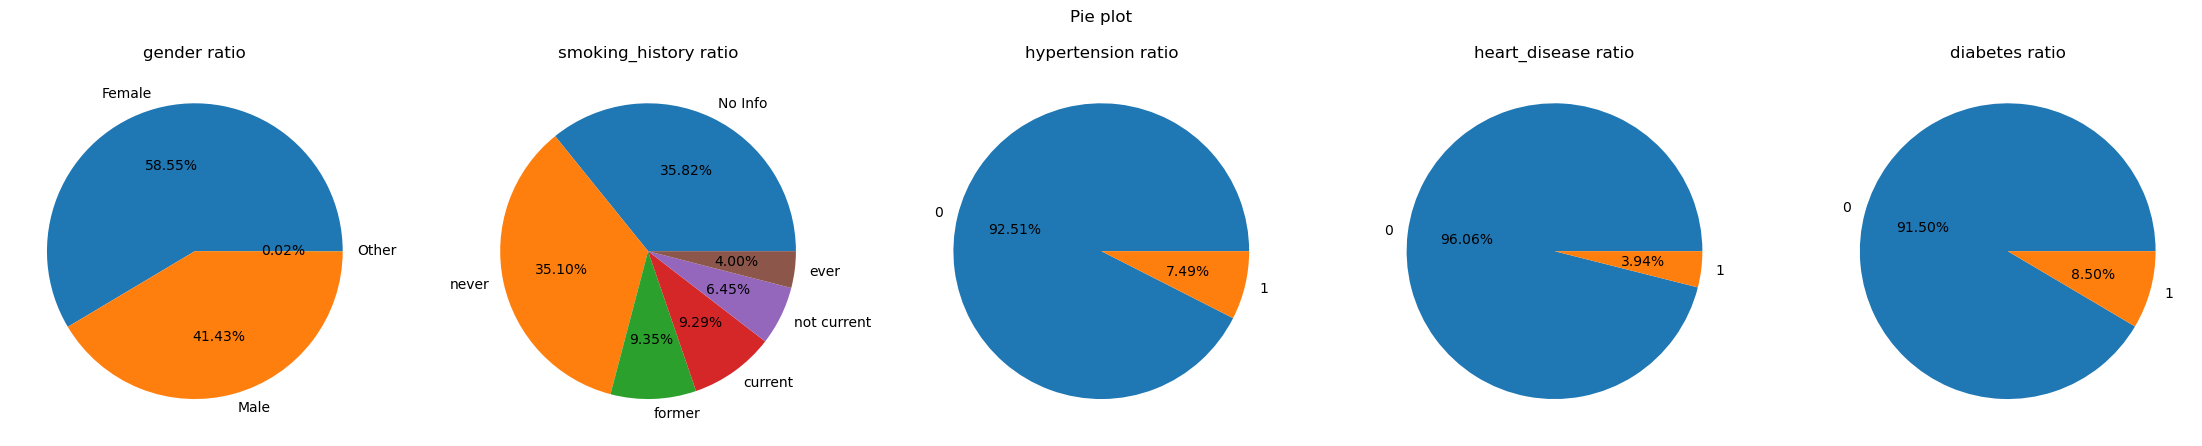

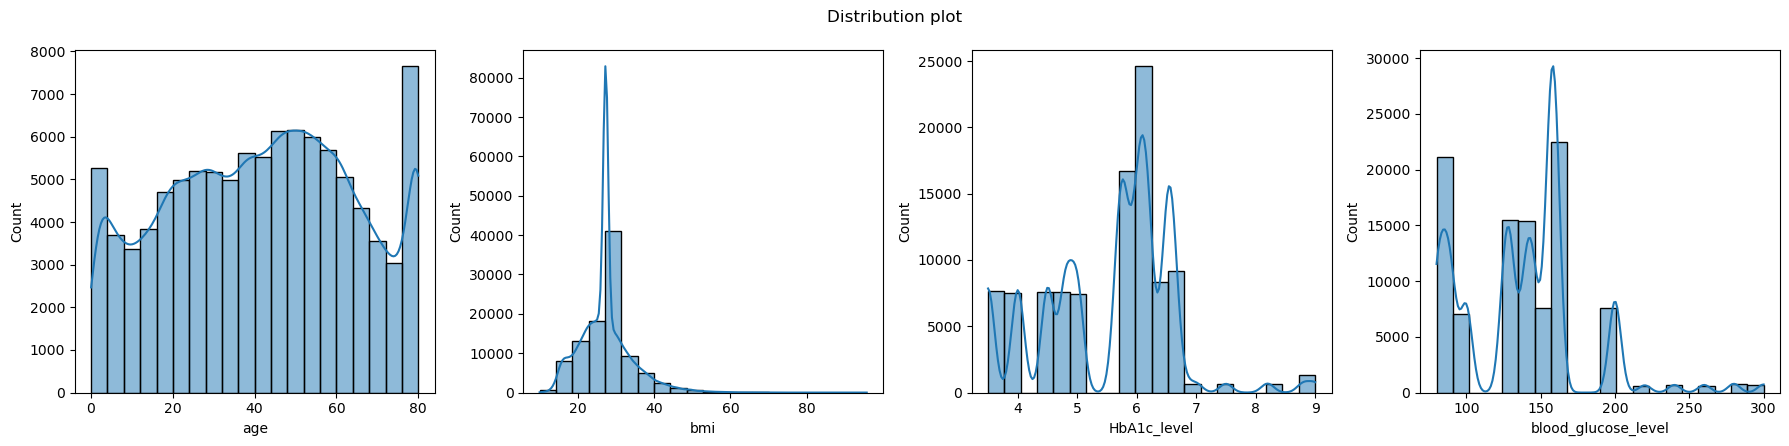

In [55]:
pie_plt(df=diabetes_df, col_ls=['gender', 'smoking_history', 'hypertension', 'heart_disease', 'diabetes']) # Review ratio of each value in categorical columns
hist_plt(diabetes_df, ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

In [56]:
diabetes_df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


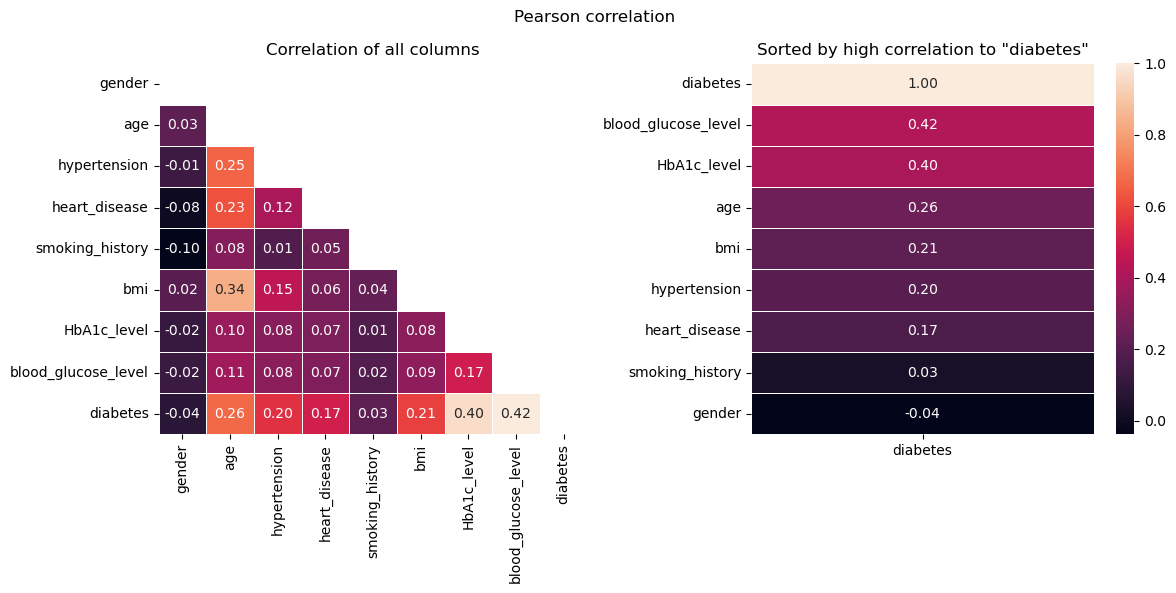

In [57]:
correlations(encoded_diabetes_df, target_column='diabetes', figsize=(12,6)) # visualize correlation between columns and target column

In [58]:
# Drop smoking_history column because it has more than 30% missing data 
df = encoded_diabetes_df.drop(columns=['smoking_history'])
data_summary_ls = dict( # getting basic insight of data
        dtypes=df.dtypes, # check datatypes of each column
        nunique=df.nunique(), # data type of each column
        NA_count=df.isna().sum(), # number of missing value in each column
        NA_percent=df.isna().mean().round(4) * 100 # percentage of missing value in each column
        )
formatted_data_summary = pd.DataFrame(data=data_summary_ls).T
formatted_data_summary

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
dtypes,float64,float64,int64,int64,float64,float64,int64,int64
nunique,2,102,2,2,4247,18,18,2
NA_count,18,0,0,0,0,0,0,0
NA_percent,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
df = df.dropna(subset=['gender'], axis=0)
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.0,80.0,0,1,25.19,6.6,140,0
1,1.0,54.0,0,0,27.32,6.6,80,0
2,0.0,28.0,0,0,27.32,5.7,158,0
3,1.0,36.0,0,0,23.45,5.0,155,0
4,0.0,76.0,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
99995,1.0,80.0,0,0,27.32,6.2,90,0
99996,1.0,2.0,0,0,17.37,6.5,100,0
99997,0.0,66.0,0,0,27.83,5.7,155,0
99998,1.0,24.0,0,0,35.42,4.0,100,0


In [60]:
df.diabetes.value_counts()

diabetes
0    91482
1     8500
Name: count, dtype: int64

In [61]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']
# stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
print(f'Training set control / case ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]}')
print(f'Test set control / case ratio: {y_test.value_counts()[0]/y_test.value_counts()[1]}')

Training set control / case ratio: 10.7625
Test set control / case ratio: 10.762941176470589


In [66]:
models = list()
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced')
model_lr.fit(X_train, y_train)

model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train, y_train)

# class_weights = compute_class_weight(class_weight='balanced', y=y_test, classes=[0,1])
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

models.append(model_lr)
models.append(model_rf)
models.append(model_xgb)

### ROCAUC & PRAUC

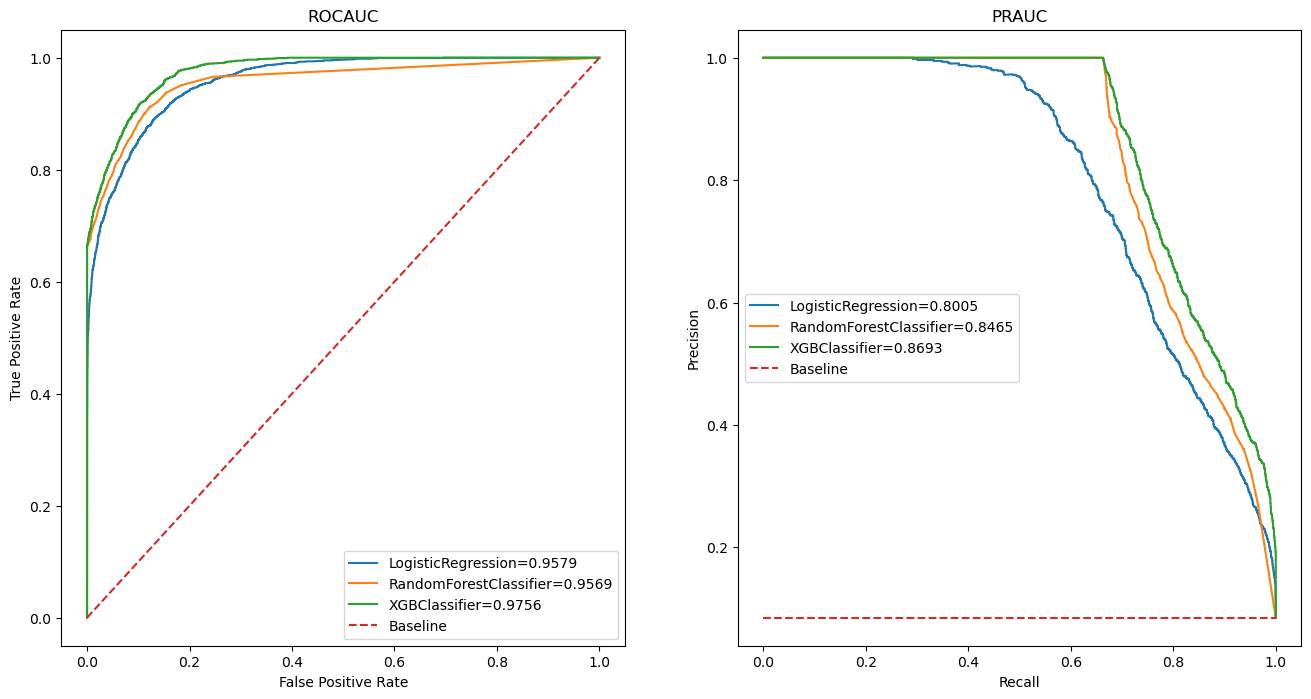

In [67]:
roc_pr_curve(models, X_test, y_test)

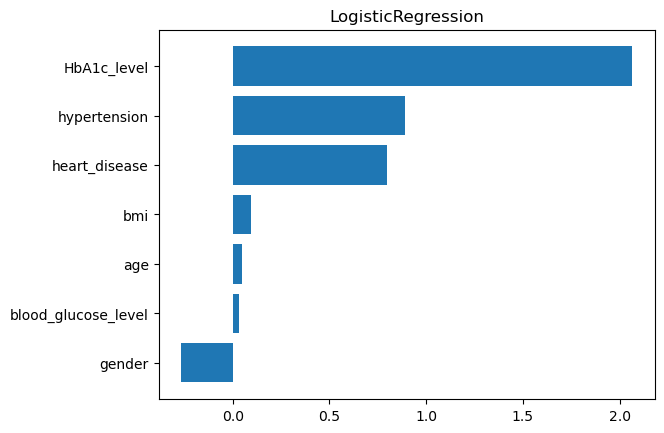

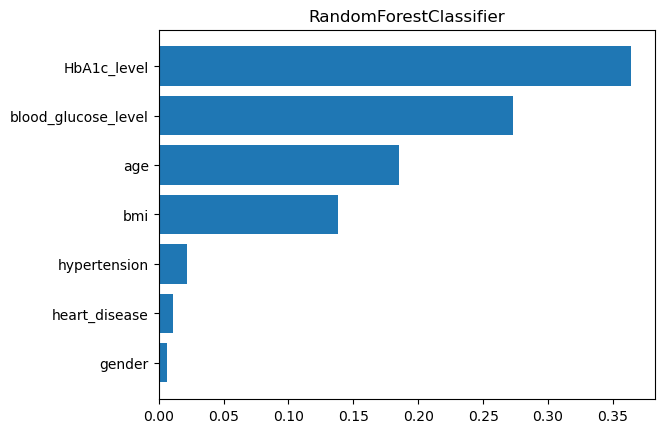

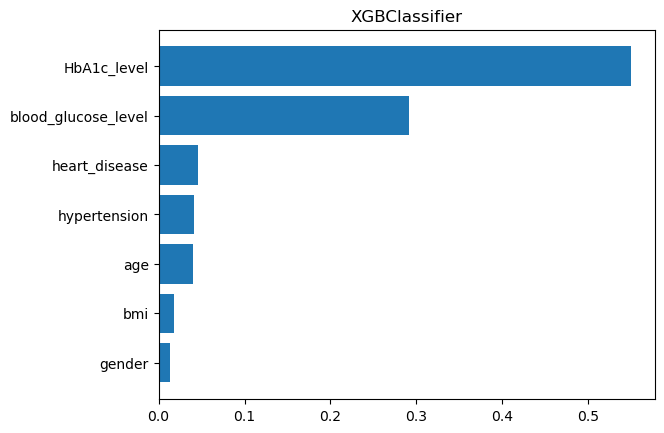

In [74]:
feature_importances(models)

### SHAP value

In [ ]:
# TODO: Add SHAP value to interpret model outcomes

### Hyper parameter tuning

In [ ]:
# TODO: Add hyper parameter tuning for each models

### Cross validation

In [ ]:
# TODO: Add cross validation